Instalar las librerías necesarias

In [1]:
pip install transformers scikit-learn pandas matplotlib seaborn tqdm

Note: you may need to restart the kernel to use updated packages.


Comprobar que el archivo .jsonl es correcto

In [14]:
import json

with open("capitulos_base_100_completo.jsonl", "r", encoding="utf-8") as f:
    for i, line in enumerate(f, 1):
        try:
            json.loads(line)
        except Exception as e:
            print(f"❌ Error en la línea {i}:\n{line}\n{e}\n")

Cargar el archivo .jsonl

In [15]:
import pandas as pd

# Cargar el JSONL en un DataFrame
df = pd.read_json("capitulos_base_100_completo.jsonl", lines=True)

# Filtrar solo los que tengan texto y clase definidos
df = df[df["texto"].str.strip() != ""]
df = df[df["clase"].str.strip() != ""]

Preparar los datos para BERT + Random Forest

1. Tokenización con BERT (bert-base-multilingual-cased es buena opción en español):

In [16]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained("bert-base-multilingual-cased")

# Codificar los textos para extraer embeddings CLS
def tokenize_and_get_cls(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding="max_length", max_length=512)
    return inputs

c:\Users\ddiaz\OneDrive\Documentos\UNIVERSIDAD EUROPEA\ENTREGABLES\TFM\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\ddiaz\OneDrive\Documentos\UNIVERSIDAD EUROPEA\ENTREGABLES\TFM\venv\Lib\site-packages\huggingface_hub\file_download.py:144: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\ddiaz\.cache\huggingface\hub\models--bert-base-multilingual-cased. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to a

2. Extraer embeddings BERT (modo sin fine-tune, solo para features):

In [18]:
from transformers import BertModel
import torch
from tqdm import tqdm
import numpy as np

model = BertModel.from_pretrained("bert-base-multilingual-cased")
model.eval()

def get_cls_embedding(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding="max_length", max_length=512)
    with torch.no_grad():
        outputs = model(**inputs)
    cls_embedding = outputs.last_hidden_state[0][0]  # primer token CLS
    return cls_embedding.numpy()

# Aplicar a todos los textos
X = []
for t in tqdm(df["texto"]):
    X.append(get_cls_embedding(t))

X = np.array(X)

100%|██████████| 172/172 [00:34<00:00,  4.95it/s]


Entrenar el Random Forest

In [19]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Convertir las clases a números
y = df["clase"].astype("category").cat.codes

# Dividir
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Entrenar el modelo
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Evaluar
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred, target_names=df["clase"].astype("category").cat.categories))


              precision    recall  f1-score   support

      humano       0.93      0.93      0.93        14
          ia       0.95      0.95      0.95        21

    accuracy                           0.94        35
   macro avg       0.94      0.94      0.94        35
weighted avg       0.94      0.94      0.94        35



Métricas y visualización

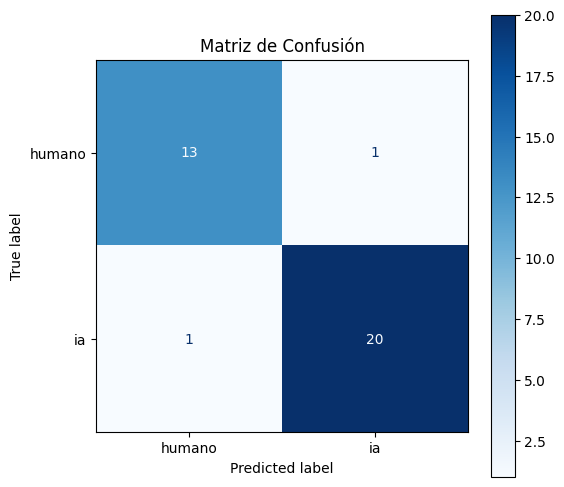

,precision,recall,f1-score,support
humano,0.928571,0.928571,0.928571,14.000000
ia,0.952381,0.952381,0.952381,21.000000
accuracy,0.942857,0.942857,0.942857,0.942857
macro avg,0.940476,0.940476,0.940476,35.000000
weighted avg,0.942857,0.942857,0.942857,35.000000


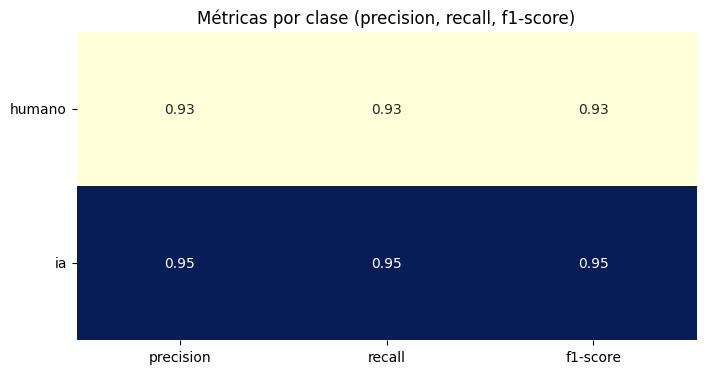

In [20]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

# Si seguiste el flujo anterior, ya tienes esto:
# - y_test: etiquetas verdaderas
# - y_pred: etiquetas predichas por el modelo
# - df: DataFrame original con la columna "clase"

# Obtener nombres de clase en orden correcto
class_names = df["clase"].astype("category").cat.categories.tolist()

# Matriz de Confusión
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
fig, ax = plt.subplots(figsize=(6, 6))
disp.plot(cmap=plt.cm.Blues, ax=ax, values_format='d')
plt.title("Matriz de Confusión")
plt.show()

# Informe de Clasificación
report = classification_report(y_test, y_pred, target_names=class_names, output_dict=True)
report_df = pd.DataFrame(report).transpose()

# Mostrar tabla de métricas
display(report_df)

# Visualizar precision, recall y f1-score
plt.figure(figsize=(8, 4))
sns.heatmap(report_df.iloc[:len(class_names), :3], annot=True, fmt=".2f", cmap="YlGnBu", cbar=False)
plt.title("Métricas por clase (precision, recall, f1-score)")
plt.yticks(rotation=0)
plt.show()

📊 Matriz de confusión
Predicho: humano	Predicho: ia
Real: humano	13	1
Real: ia	1	20

Esto significa:

Solo 2 errores en total (1 falso positivo y 1 falso negativo).

El resto, bien clasificado.

📈 Métricas por clase
Clase	Precision	Recall	F1-score
humano	0.93	0.93	0.93
ia	0.95	0.95	0.95

Accuracy global: 94.3%

🧠 Interpretación rápida:
Tu modelo distingue muy bien entre textos generados por IA y humanos.

Está equilibrado en precisión y recall, lo cual es perfecto para este tipo de problema.

No está sobreajustado a una sola clase, lo que también es una buena señal.

---------------------------------

Guardar el modelo

In [24]:
import joblib

# Guardar el modelo entrenado (por ejemplo, RandomForestClassifier)
joblib.dump(clf, "modelo_random_forest_entrenado.pkl")

['modelo_random_forest_entrenado.pkl']